# Dieting Network

## Problem statement

This neural network below wants to lose weight and go on a diet.

```
NN: I want to slim down
You: ... what?
NN: I want to have less weight! I think the less numbers I store the better.
You: (trying to think)
You: I suppose you can try sparsity? The more weights you have that are zero, then the less numbers you have to save to disk. But you must save your weights as a sparse tensor though. By default, network weights are saved as dense tensors so even if you have zero as a number, it will still take up space
NN: (scrolling on phone)
NN: I'm reading this tiktok that says Python stores integers as as objects, and so when I have one million copies of the same integer, I'm actually only using one number.
You: (thinking)
You: Uhhh
You: I feel like there are many other things that need to be done properly for your statement to stand! But most importantly though
You: How are you going to function if you practically have no weights?
NN: Well, here's where you come in to help me out!
You: Hm, but I don't know how!
NN: Hahaha
NN: You don't know how **yet!**
You: ...
You: This is so strange.
Narrator: _This is not even the strangest problem in Selection 2_
```

Do what you can to make the network below perform well when all of its weights are frozen to unity with no biases (i.e. all weights = 1 and all biases = 0). You may only adjust the activation functions. Implement whatever activation function you want!

You are given:
- a baseline network below where you are to modify `self.act1`, `self.act2` and `self.act3`
- tensors `X_train`, `y_train`, `X_val`, `y_val`, `X_test` to act as your training data, validation data and test data
- helper code to submit your predictions on `X_test` for scoring!

The following restrictions apply:

- Each activation function may contain a small amount of parameters, but have to be less than or equal to 5
- Each activation function shall be stateless during inferencing, i.e. the activation function should return the exact same answer when provided the exact same input. Inputs from a previous iteration should not affect outputs of the current iteration.

Scores shall be awarded as follows:
- 1 pt for explaining the reasoning of your approach in this notebook
- 1 pt for scoring R2 >= 0.25 while using activations that fulfill the restrictions above.
    - Submit your predictions on `X_test` via API submission. You will be scored by `sklearn.metrics.r2_score`. See example below.
    - Your score column for this problem is NOT your aggregate score, but just your R2 score on the test set!
- Additional 0 - 3 pts to be assigned based on this formula: `(Your R2 score - baseline score) / (Benchmark score - baseline score) x 3 pts`, where:
    - Benchmark score is the highest scoring R2 achieved by all participants in this problem
    - Baseline score is 0.25 R2, by default. If the lowest scoring R2 by all participants exceeds 0.25 R2, the baseline score will be set as that instead
    - e.g. max R2 score achieved is 0.5, while min R2 score achieved is 0.3. If your score is 0.4, you get (0.4 - 0.3)/(0.5 - 0.3) x 3 = 1.5 pts

## Setup

In [1]:
# YOUR EDIT HERE #
# Remember, keep your auth token to yourself!
# If you want to store this notebook in github, remember to remove your token first!
auth_token = "***REMOVED***"

In [2]:
def make_payload(x):
    # This will convert your torch tensor / numpy array
    # into a list of floats
    return {"solution": x.flatten().tolist()}

In [3]:
import requests

url = "https://competitions.aiolympiad.my/api/selection2_2025_day2/selection2_2025_dieting_network"

def post_answer(data: dict):
    response = requests.post(url=url, json=data, headers={"X-API-Key": auth_token})
    if response.status_code == 200:
        return response.json()
    else:
        return f"Failed to submit, status code is {response.status_code}\n{response.text}"

## Datasets

In [4]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dieting_network/X_train.pt -o X_train.pt
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dieting_network/X_val.pt -o X_val.pt
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dieting_network/X_test.pt -o X_test.pt
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dieting_network/y_train.pt -o y_train.pt
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dieting_network/y_val.pt -o y_val.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65180  100 65180    0     0   193k      0 --:--:-- --:--:-- --:--:--  194k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65180  100 65180    0     0   288k      0 --:--:-- --:--:-- --:--:--  300k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65180  100 65180    0     0   338k      0 --:

In [5]:
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

In [6]:
with open("X_train.pt", "rb") as f:
    X_train = torch.load(f)

with open("X_val.pt", "rb") as f:
    X_val = torch.load(f)

with open("X_test.pt", "rb") as f:
    X_test = torch.load(f)

In [7]:
with open("y_train.pt", "rb") as f:
    y_train = torch.load(f)

with open("y_val.pt", "rb") as f:
    y_val = torch.load(f)

## Baseline network

In [8]:
class FixedLinear(nn.Module):
    """
    Similar to a nn.Linear layer, just not trainable
    """

    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = torch.ones(out_features, in_features)

    def forward(self, x):
        return torch.mm(x, self.weight.t())

In [9]:
class DietNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = FixedLinear(8, 5)
        self.act1 = nn.Identity()  # <- Replace me!
        self.layer2 = FixedLinear(5, 5)
        self.act2 = nn.Identity()  # <- Replace me!
        self.layer3 = FixedLinear(5, 5)
        self.act3 = nn.Identity()  # <- Replace me!
        self.layer4 = FixedLinear(5, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        x = self.act3(x)
        x = self.layer4(x)
        return x

In [10]:
model = DietNetwork()
model.eval();

In [11]:
criterion = nn.MSELoss()

In [12]:
with torch.no_grad():
    y_train_pred = model(X_train)
    y_val_pred = model(X_val)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(
        f"train / val R2: {train_r2:.4f} / {val_r2:.4f}"
    )

train / val R2: -116767.6885 / -113389.9030


In [13]:
with torch.no_grad():
    y_test_pred = model(X_test)

In [14]:
# Should be (400, 1)
y_test_pred.shape

torch.Size([400, 1])

In [15]:
# As long as your y_test_pred follows the format of this baseline output,
# your API submission will work!
post_answer(make_payload(y_test_pred))

{'status': 'SUCCESS',
 'message': 'Answer for challenge selection2_2025_dieting_network submitted successfully on 2025-06-14 06:22:04.144426+00:00. Total submissions is 7 / 100.'}

Given code scores -0.005285602636478481.

## Your work below

In [16]:
# Read everything clearly before you start!
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

(torch.Size([1280, 8]),
 torch.Size([1280, 1]),
 torch.Size([320, 8]),
 torch.Size([320, 1]),
 torch.Size([400, 8]))

In [18]:
X_train_processed = X_train.sum(axis=1, keepdim=True)
X_val_processed = X_val.sum(axis=1, keepdim=True)

In [19]:
torch.allclose(X_train_processed * 5 ** 3, model(X_train))

True

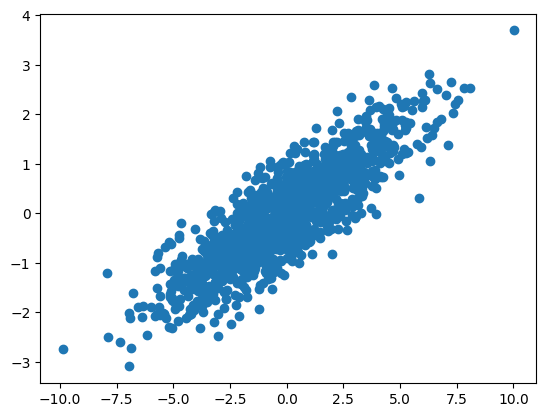

In [20]:
plt.scatter(X_train_processed, y_train);

### Explanation

The given neural network can be simplified as such:

> For each sample, the 8 features are summed and passed through a custom function (i.e., `act1`). The result is then multiplied by $5^3$ to obtain the final prediction.

I believe `act2` and `act3` play no role here other than scaling the value back. The key lies in how good we are at predicting given the sum of the 8 features. We will try linear regression, given that there is a strong linear relationship between the sum of features and the targets.

### Magic begins

In [21]:
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

y_val_pred = lr.predict(X_val_processed)
r2_score(y_val_pred, y_val)

0.668481171131134

Include `X_val_processed` and refit the model:

In [22]:
X_all = torch.concat([X_train_processed, X_val_processed], dim=0)
y_all = torch.concat([y_train, y_val], dim=0)

X_all.shape, y_all.shape

(torch.Size([1600, 1]), torch.Size([1600, 1]))

In [23]:
lr.fit(X_all, y_all)
lr.coef_, lr.intercept_

(array([[0.3155273]], dtype=float32), array([-0.00357998], dtype=float32))

In [24]:
class MyActivation(nn.Module):
    def __init__(self, weight=1, intercept=0):
        super().__init__()
        self.weight = weight
        self.intercept = intercept

    def forward(self, x):
        return self.weight * x + self.intercept

In [25]:
model.act1 = MyActivation(lr.coef_.item(), lr.intercept_.item())
model.act3 = MyActivation(1 / 5 ** 3)

### Make predictions

In [26]:
with torch.no_grad():
    y_test_pred1 = model(X_test)

In [27]:
post_answer(make_payload(y_test_pred1))

{'status': 'SUCCESS',
 'message': 'Answer for challenge selection2_2025_dieting_network submitted successfully on 2025-06-14 06:22:06.292757+00:00. Total submissions is 8 / 100.'}

This gives 0.5852730669337809.

### Strive for the better

In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [29]:
POLY_DEG = 3
polyer = PolynomialFeatures(POLY_DEG, include_bias=False)

X_train_poly = torch.tensor(polyer.fit_transform(X_train_processed))
X_val_poly = torch.tensor(polyer.fit_transform(X_val_processed))

In [30]:
lr1 = LinearRegression()
lr1.fit(X_train_poly, y_train)

y_val_pred1 = lr1.predict(X_val_poly)
r2_score(y_val_pred, y_val)

0.668481171131134

In [31]:
X_all_poly = torch.concat([X_train_poly, X_val_poly], dim=0)

X_all.shape, y_all.shape

(torch.Size([1600, 1]), torch.Size([1600, 1]))

In [32]:
lr1.fit(X_all_poly, y_all)
lr1.coef_, lr1.intercept_

(array([[ 3.17426578e-01,  2.13061958e-03, -1.01487784e-04]]),
 array([-0.01927126]))

In [33]:
class MyActivationPoly(nn.Module):
    def __init__(self, weight=1, intercept=0, degree=1):
        super().__init__()
        self.degree = degree
        self.weight = weight
        self.intercept = intercept

    def forward(self, x):
        x_poly = torch.stack([x ** (i + 1) for i in range(self.degree)], dim=-1)

        return (self.weight * x_poly).sum(dim=-1).to(torch.float32) + self.intercept

In [34]:
model.act1 = MyActivationPoly(torch.tensor(lr1.coef_), lr1.intercept_.item(), POLY_DEG)
model.act3 = MyActivationPoly(1 / 5 ** 3)

### Make predictions (again)

In [35]:
with torch.no_grad():
    y_test_pred2 = model(X_test)

In [36]:
post_answer(make_payload(y_test_pred2))

{'status': 'SUCCESS',
 'message': 'Answer for challenge selection2_2025_dieting_network submitted successfully on 2025-06-14 06:22:07.702747+00:00. Total submissions is 9 / 100.'}

This gives 0.5891765021814752.